In [67]:
from GWAPWAi import *

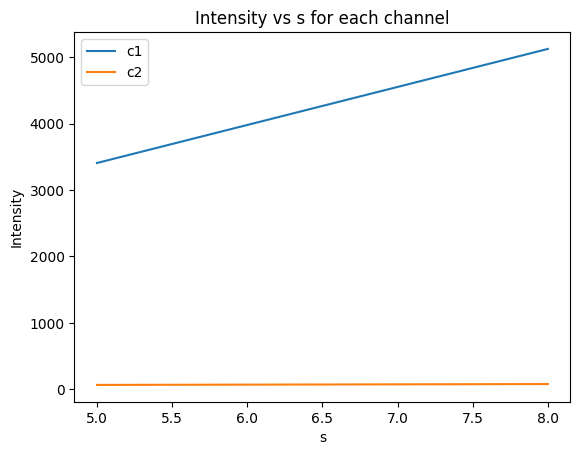

In [68]:
J = 1
alpha = 1
sL = 1.2
s0 = 1.0
smin = 0
smax = 10
c1mass = torch.tensor([5.0,6.0],dtype=torch.double)
c1coup = torch.tensor([1.0,2.0],dtype=torch.double)
c1cheby = torch.tensor([3.0,4.0],dtype=torch.double)
c2mass = torch.tensor([2.0,2.2],dtype=torch.double)
c2coup = torch.tensor([2.0,1.0],dtype=torch.double)
c2cheby = torch.tensor([2.0,3.0],dtype=torch.double)
chebys = torch.stack([c1cheby,c2cheby])
coups = torch.stack([c1coup,c2coup])
masses = torch.stack([c1mass,c2mass])
kParams = torch.stack([torch.eye(2,dtype=torch.double) for _ in range(2)], dim=0)
rmasses = torch.tensor([1.0,1.0],dtype=torch.double)
stest1 = torch.view_as_complex(torch.Tensor([5,1])).to(dtype=torch.cdouble)
stest2 = torch.view_as_complex(torch.Tensor([8,0])).to(dtype=torch.cdouble)
stests =torch.stack([stest1,stest2])
sprimetest1 = torch.view_as_complex(torch.tensor([6.2,0],dtype=torch.double)).to(dtype=torch.cdouble)
sprimetest2=torch.view_as_complex(torch.tensor([10.0,0],dtype=torch.double))
sprimetests = torch.stack([sprimetest1,sprimetest2])
test_momenta_s = momentum(stests,masses)
test_momenta_sp = momentum(sprimetests,masses)

II = torch.diag_embed(integrate_rhoN_scp(stests, masses, momentum, rhoNnominal, J, alpha, sL, 0, 0.0001,10000000))
N=numerator(omega_pole(stests,s0),chebys).unsqueeze(1)
phsp = construct_phsp(stests,masses,J)
kmat = K_nominal(stests,coups,rmasses,kParams)
num_pts = stests.shape[0]
num_ch = kmat.shape[1]
denom_inv = ((torch.eye(num_ch).expand(num_pts,num_ch,num_ch)-kmat@II).inverse()@kmat)
val = (N@denom_inv@phsp).squeeze(1)
intensity = (val*torch.conj(val)).real
s_np = stests.detach().cpu().numpy().real
intensity_np = intensity.detach().cpu().numpy()
ch_labels = ["c1","c2"]
for i, label in enumerate(ch_labels):
    plt.plot(s_np, intensity_np[:, i], label=label)

plt.xlabel("s")
plt.ylabel("Intensity")
plt.title("Intensity vs s for each channel")
plt.legend()
plt.show()

In [69]:
instructions = parse_file("test_input.in")
observ_dict = reorganize_instructions(instructions)
observ_dict

{'channels': {'names': ['BB', 'BBstar', 'Dummy'],
  'masses': tensor([[5.2793, 5.2793],
          [5.2793, 5.3247],
          [5.3669, 5.4154]], dtype=torch.float64)},
 'waves': ['P'],
 'wave_data': {'P': {'kmat_type': 'kmat-nominal',
   'rhoN_type': 'rhoN-nominal',
   'J': 1,
   'sL': -81.0,
   'ChebyCoeffs': {'s': ['s = 1', 's = 1', 's = 1'],
    'coeffs': tensor([[-35.4173, -77.8781,   3.5862],
            [ -5.2296, -29.7685,  24.3869],
            [-57.5724, -92.0912, -54.3529]], dtype=torch.float64),
    'errors': tensor([[200., 200., 200.],
            [200., 200., 200.],
            [200., 200., 200.]], dtype=torch.float64)},
   'Poles': {'mass': tensor([ 56.9939, 115.2649]),
    'mass_err': tensor([5., 5.]),
    'couplings': tensor([[  98.0560,    2.7856],
            [ -10.3198,    4.9220],
            [-103.8100,   -2.1059]], dtype=torch.float64),
    'coupling_err': tensor([[200., 200.],
            [200., 200.],
            [200., 200.]], dtype=torch.float64)},
   'KmatBac

In [70]:
J = observ_dict["wave_data"]["P"]["J"]
alpha = 1
sL = observ_dict["wave_data"]["P"]["sL"]
s0 = 1
smin,smax = observ_dict["fitting"]["FitRegion"]
masses = observ_dict["channels"]["masses"]
chebys = observ_dict["wave_data"]["P"]["ChebyCoeffs"]["coeffs"]
pole_couplings = observ_dict["wave_data"]["P"]["Poles"]["couplings"]
pole_masses = observ_dict["wave_data"]["P"]["Poles"]["mass"]
ktype = observ_dict["wave_data"]["P"]["kmat_type"]
rhoNtype = observ_dict["wave_data"]["P"]["rhoN_type"]
kbkgrd = observ_dict["wave_data"]["P"]["KmatBackground"]

In [77]:
stests = torch.tensor([10.7**2,11.0**2])
phsp = construct_phsp(stests,masses,J).to(torch.cdouble)

torch.Size([2, 3, 3])

In [94]:
N =numerator(omega_pole(stests,s0),chebys).unsqueeze(1).to(torch.cdouble)
kmat = K_nominal(stests, pole_couplings, pole_masses, kbkgrd)
print(kmat)

tensor([[[ 3.5240e+01+0.j,  3.2983e+01+0.j, -1.2882e+01+0.j],
         [ 9.7893e+01+0.j,  2.8928e+01+0.j, -3.2009e+01+0.j],
         [ 4.0198e+02+0.j, -3.2009e+01+0.j, -1.8171e+02+0.j]],

        [[-1.7269e+00+0.j, -1.2226e+01+0.j, -4.5548e-02+0.j],
         [ 4.1631e+01+0.j,  9.2035e+00+0.j, -1.4930e+01+0.j],
         [ 3.4511e+02+0.j, -1.4930e+01+0.j, -1.6914e+02+0.j]]],
       dtype=torch.complex128)


In [87]:
II = torch.diag_embed(integrate_rhoN_scp(stests, masses, momentum, rhoNnominal, J, alpha, sL, 0, 0.0001,10000000))
print(II)

tensor([[[0.0457+4.6517e-03j, 0.0000+0.0000e+00j, 0.0000+0.0000e+00j],
         [0.0000+0.0000e+00j, 0.0429+2.6095e-03j, 0.0000+0.0000e+00j],
         [0.0000+0.0000e+00j, 0.0000+0.0000e+00j, 0.0322+1.0214e-07j]],

        [[0.0503+1.2413e-06j, 0.0000+0.0000e+00j, 0.0000+0.0000e+00j],
         [0.0000+0.0000e+00j, 0.0491+1.5642e-02j, 0.0000+0.0000e+00j],
         [0.0000+0.0000e+00j, 0.0000+0.0000e+00j, 0.0426+6.4544e-03j]]],
       dtype=torch.complex128)


/Users/wyatt/Development/GWAi/GWAPWAi/amplitude.py:254: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  imag_int, imag_err = quad(lambda t: np.imag(integrand(t)),


In [114]:
N.reshape(2,3,1)

tensor([[[-109.1585+0.j],
         [ -11.1944+0.j],
         [-201.3448+0.j]],

        [[-109.1879+0.j],
         [ -11.1635+0.j],
         [-201.4869+0.j]]], dtype=torch.complex128)

In [116]:
((torch.eye(num_ch).expand(num_pts,num_ch,num_ch)-kmat@II).inverse()@kmat)

tensor([[[-18.1177+1.9761j, -12.2630+1.9343j,   2.1779-0.2499j],
         [-13.1399+2.0726j, -27.1650+2.7131j,   1.9576-0.2763j],
         [ 12.1922+0.1006j, -32.6173+1.6292j, -21.0083-0.0443j]],

        [[ -9.8404-2.7709j, -12.3325-0.6237j,   1.1141+0.2590j],
         [ 14.9726+0.2670j,   2.1956+0.4365j,  -1.9843+0.1624j],
         [ 18.7105-8.8007j, -27.7935+2.2736j, -17.6694+2.9394j]]],
       dtype=torch.complex128)

In [119]:
stests

tensor([114.4900, 121.0000])

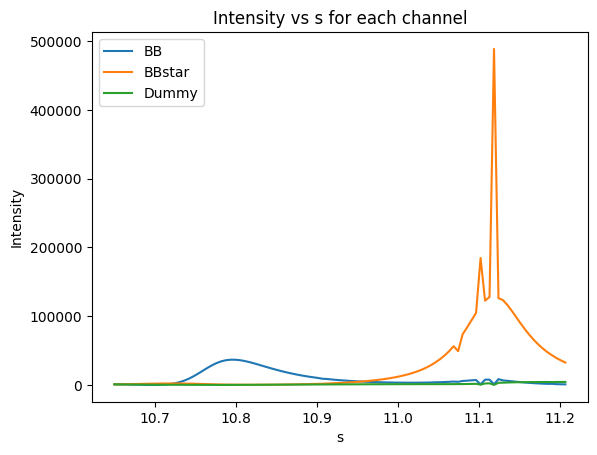

In [ ]:
svals = torch.linspace(smin**2, smax**2, 100, dtype=torch.cdouble)

N = numerator(omega_pole(svals, s0), chebys).unsqueeze(1).to(torch.cdouble)
phsp = construct_phsp(svals, masses, J)


val = (N @ denom_inv @ phsp).squeeze(1)
intensity = (val * torch.conj(val)).real

s_np = (svals**0.5).detach().cpu().numpy().real
intensity_np = intensity.detach().cpu().numpy()
ch_labels = ["BB", "BBstar", "Dummy"]

for i, label in enumerate(ch_labels):
    plt.plot(s_np, intensity_np[:, i], label=label)

plt.xlabel("s")
plt.ylabel("Intensity")
plt.title("Intensity vs s for each channel")
plt.legend()
plt.show()



In [36]:
phsp.shape

torch.Size([100, 3, 3])

In [5]:
exp_data = load_experimental_data(observ_dict)
exp_data['P']["channels"]["BB"].shape

torch.Size([27, 5])

In [6]:
def pack_parameters(observ_dict, wave="P"):
    """
    Packs model parameters into a flat vector for optimization, and provides
    an unpacking function to restore them.

    Returns:
        flat_params (tensor): 1D tensor of all parameters
        unpack_fn (function): callable to get original tensors back
        static_params (dict): non-learnable config values
    """
    wave_data = observ_dict["wave_data"][wave]
    chebys = wave_data["ChebyCoeffs"]["coeffs"]
    pole_couplings = wave_data["Poles"]["couplings"]
    pole_masses = wave_data["Poles"]["mass"]
    kbkgrd = wave_data["KmatBackground"]
    masses = observ_dict["channels"]["masses"]

    # Collect shapes and flat tensors
    tensors = [chebys, pole_couplings, pole_masses, kbkgrd]
    shapes = [t.shape for t in tensors]
    sizes = [t.numel() for t in tensors]
    flat_parts = [t.reshape(-1) for t in tensors]

    # Combine everything
    flat_params = torch.cat(flat_parts)

    def unpack_fn(flat_vector):
        """Unpacks the flat vector into the original tensors."""
        idx = 0
        restored = []
        for shape, size in zip(shapes, sizes):
            chunk = flat_vector[idx:idx+size].reshape(shape)
            restored.append(chunk)
            idx += size
        return restored  # chebys, pole_couplings, pole_masses, kbkgrd

    static_params = {
        "J": wave_data["J"],
        "alpha": 1,
        "sL": wave_data["sL"],
        "s0": 1,
        "smin": observ_dict["fitting"]["FitRegion"][0],
        "smax": observ_dict["fitting"]["FitRegion"][1],
        "ktype": wave_data["kmat_type"],
        "rhoNtype": wave_data["rhoN_type"],
        "masses": masses
    }

    return flat_params, unpack_fn, static_params


In [7]:
def compute_intensity(s, flat_params, unpack_fn, static_params,
                      integrate_rhoN_func, numerator_func, 
                      omega_pole_func, construct_phsp_func, 
                      K_nominal_func, momentum_func):
    """
    Computes the full model intensity over input s.

    Args:
        s (tensor): shape (K,), the energy values
        flat_params (tensor): 1D tensor containing all model parameters
        unpack_fn (function): returns chebys, pole_couplings, pole_masses, kbkgrd
        static_params (dict): includes J, alpha, sL, s0, ktype, rhoNtype, masses
        *_func: external functions (e.g., integrate_rhoN_scp, K_nominal, etc.)

    Returns:
        intensity (tensor): shape (K, M), real-valued model prediction
    """
    import matplotlib.pyplot as plt

    chebys, pole_couplings, pole_masses, kbkgrd = unpack_fn(flat_params)

    J = static_params["J"]
    alpha = static_params["alpha"]
    sL = static_params["sL"]
    s0 = static_params["s0"]
    ktype = static_params["ktype"]
    masses = static_params["masses"]
    channel_names = static_params.get("channel_names", [f"ch{i}" for i in range(masses.shape[0])])

    # Dispatcher for rhoN functions
    rhoN_dispatcher = {
        "rhoN-nominal": rhoNnominal,
        # Add other mappings here
    }
    rhoNtype_str = static_params.get("rhoN_type", "rhoN-nominal")
    rhoN_fn = rhoN_dispatcher[rhoNtype_str]

    # Evaluate components
    II = torch.diag_embed(
        integrate_rhoN_func(s, masses, momentum_func, rhoN_fn, J, alpha, sL, 0, 0.0001, 10000000)
    )
    N = numerator_func(omega_pole_func(s, s0), chebys).unsqueeze(1)
    phsp = construct_phsp_func(s, masses, J)
    kmat = K_nominal_func(s, pole_couplings, pole_masses, kbkgrd)

    num_pts = s.shape[0]
    num_ch = kmat.shape[1]

    identity = torch.eye(num_ch, dtype=s.dtype, device=s.device).expand(num_pts, num_ch, num_ch)
    denom_inv = (identity - kmat @ II).inverse() @ kmat

    val = (N @ denom_inv @ phsp).squeeze(1)
    intensity = (val * torch.conj(val)).real

    # Plotting
    s_np = s.detach().cpu().numpy().real
    intensity_np = intensity.detach().cpu().numpy()
    for i in range(intensity_np.shape[1]):
        plt.plot(s_np, intensity_np[:, i], label=channel_names[i])
    plt.xlabel("s")
    plt.ylabel("Intensity")
    plt.legend()
    plt.title("Model Intensity per Channel")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return intensity


In [8]:
observ_dict = reorganize_instructions(parse_file("test_input.in"))
flat_params, unpack_fn, static_params = pack_parameters(observ_dict, wave="P")
static_params["channel_names"] = observ_dict["channels"]["names"]  # add channel labels

# Define energy range (s-values)
s_vals = torch.linspace(static_params["smin"], static_params["smax"], steps=500, dtype=torch.cdouble)

# Compute and plot intensity
intensity = compute_intensity(
    s=s_vals,
    flat_params=flat_params,
    unpack_fn=unpack_fn,
    static_params=static_params,
    integrate_rhoN_func=integrate_rhoN_scp,
    numerator_func=numerator,
    omega_pole_func=omega_pole,
    construct_phsp_func=construct_phsp,
    K_nominal_func=K_nominal,
    momentum_func=momentum
)


RuntimeError: The size of tensor a (3) must match the size of tensor b (2) at non-singleton dimension 2

In [ ]:
def compute_residuals_batched(model_function, config, exp_data, wave="P"):
    """
    Vectorized residual computation for a model returning intensity[s, channel].
    
    Parameters:
        model_function: Callable(s: Tensor, **kwargs) -> Tensor (K_total, num_channels)
        config: reorganized instruction dictionary
        exp_data: result of load_experimental_data(config)
        wave: wave label (e.g., "P")
    
    Returns:
        residuals: 1D tensor of residuals from all channels and inclusive data
    """
    wave_config = config["wave_data"][wave]
    channel_names = config["channels"]["names"]
    channel_data = exp_data[wave]["channels"]
    inclusive_data = exp_data[wave]["inclusive"]

    # Extract model kwargs from config
    kwargs = {
        "masses": config["channels"]["masses"],
        "chebys": wave_config["ChebyCoeffs"]["coeffs"],
        "pole_masses": wave_config["Poles"]["mass"],
        "pole_couplings": wave_config["Poles"]["couplings"],
        "kbkgrd": wave_config["KmatBackground"],
        "J": wave_config["J"],
        "alpha": 1,
        "sL": wave_config["sL"],
        "s0": 1,
        "ktype": wave_config["kmat_type"],
        "rhoNtype": wave_config["rhoN_type"],
    }

    # --- Step 1: Collect all s-values and corresponding metadata
    s_vals_list = []
    s_targets = []
    s_channels = []
    for ch_idx, ch in enumerate(channel_names):
        if ch in channel_data and channel_data[ch] is not None:
            s = channel_data[ch][:, 0]
            y = channel_data[ch][:, 1]
            s_vals_list.append(s)
            s_targets.append(y)
            s_channels.append(torch.full_like(s, ch_idx))

    if inclusive_data is not None:
        s = inclusive_data[:, 0]
        y = inclusive_data[:, 1]
        s_vals_list.append(s)
        s_targets.append(y)
        s_channels.append(torch.full_like(s, -1))  # use -1 to mark inclusive

    s_all = torch.cat(s_vals_list)                     # shape: (T,)
    y_all = torch.cat(s_targets)                       # shape: (T,)
    ch_all = torch.cat(s_channels)                     # shape: (T,)

    # --- Step 2: Get unique s-values and inverse mapping
    s_unique, inverse = torch.unique(s_all, sorted=True, return_inverse=True)
    intensity_all = model_function(s_unique, **kwargs)  # shape: (K, C)

    # --- Step 3: Map back to full model values
    intensity_indexed = intensity_all[inverse]  # shape: (T, C)

    # --- Step 4: Compute residuals
    # For exclusive: pick per-channel component
    is_exclusive = (ch_all != -1)
    exclusive_idx = torch.where(is_exclusive)[0]
    ch_excl = ch_all[exclusive_idx]
    model_excl = intensity_indexed[exclusive_idx, ch_excl]
    resid_excl = model_excl - y_all[exclusive_idx]

    # For inclusive: sum over channels
    is_inclusive = (ch_all == -1)
    incl_idx = torch.where(is_inclusive)[0]
    model_incl = intensity_indexed[incl_idx].sum(dim=1)
    resid_incl = model_incl - y_all[incl_idx]

    # --- Step 5: Combine
    residuals = torch.cat([resid_excl, resid_incl])
    return residuals


In [ ]:
def prepare_fitting_data(exp_data, config, wave="P", device="cuda"):
    """
    Prepares data for batched, vectorized residual computation with uncertainties.
    Now handles experimental data with shape (N, 3): [s, y, sigma].

    Returns:
        dict of tensors on device with keys:
            s_unique, inverse, channel_indices, y_targets, y_errors,
            is_exclusive, is_inclusive
    """
    channel_names = config["channels"]["names"]
    channel_data = exp_data[wave]["channels"]
    inclusive_data = exp_data[wave]["inclusive"]

    s_all, y_all, sigma_all, ch_all = [], [], [], []

    for ch_idx, ch in enumerate(channel_names):
        if ch in channel_data and channel_data[ch] is not None:
            data = channel_data[ch]  # shape (N, 3)
            s_all.append(data[:, 0])
            y_all.append(data[:, 1])
            sigma_all.append(data[:, 2])
            ch_all.append(torch.full_like(data[:, 0], ch_idx))

    if inclusive_data is not None:
        s_all.append(inclusive_data[:, 0])
        y_all.append(inclusive_data[:, 1])
        sigma_all.append(inclusive_data[:, 2])
        ch_all.append(torch.full_like(inclusive_data[:, 0], -1))  # inclusive

    s_all = torch.cat(s_all)
    y_all = torch.cat(y_all)
    sigma_all = torch.cat(sigma_all)
    ch_all = torch.cat(ch_all)

    s_unique, inverse = torch.unique(s_all, sorted=True, return_inverse=True)

    return {
        "s_unique": s_unique.to(device),
        "inverse": inverse.to(device),
        "channel_indices": ch_all.to(device),
        "y_targets": y_all.to(device),
        "y_errors": sigma_all.to(device),
        "is_exclusive": (ch_all != -1).to(device),
        "is_inclusive": (ch_all == -1).to(device),
    }


In [ ]:
def compute_residuals_vectorized(model_function, prepared_data, config, wave="P"):
    """
    Computes weighted residuals for all data, given preprocessed experimental data.

    Returns:
        weighted residuals: shape (T,)
    """
    wave_config = config["wave_data"][wave]
    kwargs = {
        "masses": config["channels"]["masses"].to(prepared_data["s_unique"].device),
        "chebys": wave_config["ChebyCoeffs"]["coeffs"].to(prepared_data["s_unique"].device),
        "pole_masses": wave_config["Poles"]["mass"].to(prepared_data["s_unique"].device),
        "pole_couplings": wave_config["Poles"]["couplings"].to(prepared_data["s_unique"].device),
        "kbkgrd": wave_config["KmatBackground"].to(prepared_data["s_unique"].device),
        "J": wave_config["J"],
        "alpha": 1,
        "sL": wave_config["sL"],
        "s0": 1,
        "ktype": wave_config["kmat_type"],
        "rhoNtype": wave_config["rhoN_type"],
    }

    s_unique = prepared_data["s_unique"]
    inverse = prepared_data["inverse"]
    ch_all = prepared_data["channel_indices"]
    y_all = prepared_data["y_targets"]
    sigma_all = prepared_data["y_errors"]

    intensity = model_function(s_unique, **kwargs)  # (K, C)
    intensity_mapped = intensity[inverse]           # (T, C)

    # Exclusive residuals
    excl_mask = prepared_data["is_exclusive"]
    idx_excl = torch.where(excl_mask)[0]
    ch_excl = ch_all[idx_excl]
    model_excl = intensity_mapped[idx_excl, ch_excl]
    resid_excl = (model_excl - y_all[idx_excl]) / sigma_all[idx_excl]

    # Inclusive residuals (sum over channels)
    incl_mask = prepared_data["is_inclusive"]
    idx_incl = torch.where(incl_mask)[0]
    model_incl = intensity_mapped[idx_incl].sum(dim=1)
    resid_incl = (model_incl - y_all[idx_incl]) / sigma_all[idx_incl]

    return torch.cat([resid_excl, resid_incl])  # shape (T,)


In [ ]:
def make_closure(model_function, prepared_data, config, wave, param_list, loss_container=None):
    """
    Returns a closure for torch.optim that:
    - zeroes gradients
    - computes residuals
    - returns weighted sum of squares loss
    - stores loss (optional)
    """
    def closure():
        for p in param_list:
            if p.grad is not None:
                p.grad.zero_()

        residuals = compute_residuals_vectorized(model_function, prepared_data, config, wave)
        loss = torch.sum(residuals**2)

        if loss_container is not None:
            loss_container.append(loss.item())

        loss.backward()
        return loss

    return closure


In [ ]:
def pack_parameters(observ_dict, wave="P"):
    """
    Packs model parameters into a flat vector for optimization, and provides
    an unpacking function to restore them.

    Returns:
        flat_params (tensor): 1D tensor of all parameters
        unpack_fn (function): callable to get original tensors back
        static_params (dict): non-learnable config values
    """
    wave_data = observ_dict["wave_data"][wave]
    chebys = wave_data["ChebyCoeffs"]["coeffs"]
    pole_couplings = wave_data["Poles"]["couplings"]
    pole_masses = wave_data["Poles"]["mass"]
    kbkgrd = wave_data["KmatBackground"]
    masses = observ_dict["channels"]["masses"]

    # Collect shapes and flat tensors
    tensors = [chebys, pole_couplings, pole_masses, kbkgrd]
    shapes = [t.shape for t in tensors]
    sizes = [t.numel() for t in tensors]
    flat_parts = [t.reshape(-1) for t in tensors]

    # Combine everything
    flat_params = torch.cat(flat_parts)

    def unpack_fn(flat_vector):
        """Unpacks the flat vector into the original tensors."""
        idx = 0
        restored = []
        for shape, size in zip(shapes, sizes):
            chunk = flat_vector[idx:idx+size].reshape(shape)
            restored.append(chunk)
            idx += size
        return restored  # chebys, pole_couplings, pole_masses, kbkgrd

    static_params = {
        "J": wave_data["J"],
        "alpha": 1,
        "sL": wave_data["sL"],
        "s0": 1,
        "smin": observ_dict["fitting"]["FitRegion"][0],
        "smax": observ_dict["fitting"]["FitRegion"][1],
        "ktype": wave_data["kmat_type"],
        "rhoNtype": wave_data["rhoN_type"],
        "masses": masses
    }

    return flat_params, unpack_fn, static_params


In [ ]:
params, unpack_fn, static = pack_parameters(observ_dict)

# Make it a leaf tensor with grad
params = params.clone().detach().requires_grad_(True)

# Use in torch.optim
optimizer = torch.optim.LBFGS([params], max_iter=100)

# Define model wrapper
def model_function(s, params):
    chebys, pole_couplings, pole_masses, kbkgrd = unpack_fn(params)
    return your_amplitude_model(s, chebys, pole_couplings, pole_masses, kbkgrd, **static)

# Setup closure (as before)
closure = make_closure(model_function, prepared_data, observ_dict, "P", [params])
optimizer.step(closure)


In [ ]:
def build_model_function(unpack_fn, static_params,
                         integrate_rhoN_scp, numerator, omega_pole,
                         construct_phsp, K_nominal, momentum):
    """
    Returns a function that evaluates the full intensity model:
    intensity(s) -> tensor of shape (K, num_channels)

    Arguments:
        unpack_fn      -- function to unpack packed parameter vector
        static_params  -- dict containing J, alpha, sL, s0, ktype, rhoNtype, masses, etc.
        Subfunctions   -- required physics model components
    """
    def model_fn(s, flat_params):
        chebys, pole_couplings, pole_masses, kbkgrd = unpack_fn(flat_params)
        J = static_params["J"]
        alpha = static_params["alpha"]
        sL = static_params["sL"]
        s0 = static_params["s0"]
        ktype = static_params["ktype"]
        rhoNtype = static_params["rhoNtype"]
        masses = static_params["masses"]

        # Compute each component
        II = torch.diag_embed(integrate_rhoN_scp(s, masses, momentum, rhoNtype, J, alpha, sL, 0, 1e-4, 10000000))
        N = numerator(omega_pole(s, s0), chebys).unsqueeze(1)
        phsp = construct_phsp(s, masses, J)
        kmat = K_nominal(s, pole_couplings, pole_masses, masses, kbkgrd)

        num_pts, num_ch = s.shape[0], kmat.shape[1]
        eye = torch.eye(num_ch, dtype=s.dtype, device=s.device).expand(num_pts, num_ch, num_ch)

        denom_inv = (eye - kmat @ II).inverse() @ kmat
        val = (N @ denom_inv @ phsp).squeeze(1)
        intensity = (val * torch.conj(val)).real
        return intensity  # shape: (K, num_channels)

    return model_fn


In [ ]:
# Unpack your dictionary
flat_params, unpack_fn, static = pack_parameters(observ_dict)

# Move to GPU and enable gradient
flat_params = flat_params.clone().detach().to("cuda").requires_grad_()

# Prepare experimental data and preprocessing
exp_data = load_experimental_data(observ_dict)
prep = prepare_fitting_data(exp_data, observ_dict, wave="P", device="cuda")

# Build model function from unpack + physics parts
model_fn = build_model_function(
    unpack_fn,
    static,
    integrate_rhoN_scp,
    numerator,
    omega_pole,
    construct_phsp,
    K_nominal,
    momentum
)

# Use in closure
closure = make_closure(model_fn, prep, observ_dict, "P", [flat_params])
optimizer = torch.optim.LBFGS([flat_params], lr=1.0, max_iter=100)
optimizer.step(closure)


In [ ]:
def plot_model_vs_data(model_fn, flat_params, prepared_data, observ_dict, wave="P", save_path=None):
    """
    Plots model predictions vs experimental data (exclusive + inclusive).
    
    Args:
        model_fn: function (s, flat_params) -> intensity (K, C)
        flat_params: packed torch tensor with grad
        prepared_data: output from prepare_fitting_data()
        observ_dict: original instruction dictionary
        wave: string name of the wave
        save_path: optional path to save the figure (e.g. "fit_result.png")
    """
    s = prepared_data["s_unique"].detach().cpu()
    intensity = model_fn(s.to(flat_params.device), flat_params).detach().cpu()
    
    ch_names = observ_dict["channels"]["names"]
    data = observ_dict["wave_data"][wave]["LoadExpData"]
    inclusive_data = data.get("inclusive", None)

    plt.figure(figsize=(10, 6))
    colors = plt.cm.tab10.colors

    # Plot exclusive channels
    for i, name in enumerate(ch_names):
        if name in data:
            d = data[name]
            plt.errorbar(d[:, 0], d[:, 1], yerr=d[:, 2], fmt='o', label=f"Exp {name}", color=colors[i % 10])
            plt.plot(s, intensity[:, i], label=f"Model {name}", linestyle='-', color=colors[i % 10])

    # Plot inclusive
    if inclusive_data is not None:
        d = inclusive_data
        plt.errorbar(d[:, 0], d[:, 1], yerr=d[:, 2], fmt='o', label="Exp inclusive", color="black")
        plt.plot(s, intensity.sum(dim=1), label="Model inclusive", linestyle='--', color="black")

    plt.xlabel("s")
    plt.ylabel("Intensity")
    plt.legend()
    plt.title(f"Model vs Experimental Data ({wave} wave)")
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"Plot saved to {save_path}")
    else:
        plt.show()
